(sec:ci)=
# Configuration interaction
## General theory

One of the conceptually (but not computationally) simplest way to solve the Schrödinger equation is to simply expand our many-body wave function on a $N$-electron basis set (not to be confused with the one-electron basis functions used to expand orbitals)

$$
| \Psi_{\text{CI}} \rangle = \sum_k c_k | \mathbf{k} \rangle 
$$

with energy

(eq:CIene)=
$$
E_{\text{CI}} = \frac{\langle \Psi_{\text{CI}} | \hat{H} | \Psi_{\text{CI}} \rangle}{\langle \Psi_{\text{CI}} | \Psi_{\text{CI}} \rangle} 
$$

As the size of this basis set increases, the solution converges to the exact solution of the Schrödinger equation.

There is a redundancy in the parameters $c_k$, as multiplying them all by a constant does not change the energy. We thus add the constraint that the wave function should be normalized

$$
\langle \Psi_{\text{CI}} | \Psi_{\text{CI}} \rangle = \sum_k c_k^2 = 1
$$

To minimize the wave function subject to this constraint, we write a Lagrangian

$$
L = E - \epsilon(\sum_k c_k^2 -1)
$$

To define our minimization we set the gradient of our Lagrangian to 0 and obtain

$$
\frac{\mathrm{d}L}{\mathrm{d} c_k} =  \sum_i \langle \mathbf{i} | \hat{H} | \mathbf{k} \rangle c_i - \epsilon c_k + \text{c.c.}= 0 \, 
$$

where "$\text{c.c.}$" denotes the complex conjugate of the previous expression. This can finally be recast in the familiar form

$$
\mathbf{H} \mathbf{c} = \epsilon \mathbf{c}
$$

showing that minimizing the CI energy energy is equivalent to diagonalizing the Hamiltonian matrix in our chosen basis, with the eigenvalues being the energies of all possible states in the system. The ground state simply corresponds to the lowest eigenvalue.

## The $N$-electron basis

There are in principle an infinite number of possible $N$-electron basis to choose from, but we ideally want the expansion to converge quickly (compact expansion) and the functions to be easily manipulable to efficiently compute the Hamiltonian elements. Unfortunately, these two criteria often oppose each other.

As electron correlation depends on the distance between electrons, it would be natural to use functions that depend explicitly on this distance, the same way as our Gaussian or Slater one-electron basis depends explicitly on the distance between electron and nuclei. Wave functions having these properties are typically called explicitly correlated wave functions, but this interelectronic distance makes the calculation of integrals very difficult as it couples multiple electrons together.

We often drop this explicit dependence and instead use a wave function that is formed from products of one-electron functions, *i.e.*, a product of orbitals. The simplest of these basis functions is the [Hartree product](https://en.wikipedia.org/wiki/Hartree_equation), but since we know the wave function should be antisymmetric with respect to the exchange of two electrons, we instead use the antisymmetrised version of the Hartree product: [Slater determinants (SDs)](sec:slater). As each SD represents a different electronic configuration, the resulting method is called configuration interaction (CI). As discussed in the previous sections, this basis of SDs constitutes a complete basis within a specified one-electron basis set, and thus the solution obtained by minimizing the energy of this wave function is the exact ground state within that one-electron basis.

In some codes, [configuration state functions (CSFs)](https://en.wikipedia.org/wiki/Configuration_state_function) are used instead of SDs. CSFs are fixed linear combinations of SDs but with the attractive properties that they are also eigenfunctions of the $\hat{S}^2$ spin operator. This spin constraints means that the resulting wave function will always be spin-adapted and also that CSFs are less numerous than Slater determinants, which has advantages on a computational standpoint. However, SDs can be expressed as ordered "strings" of $\alpha$ and $\beta$ creation operators, and this separation of $\alpha$ and $\beta$ electrons allows for efficient computer implementations, outweighing the benefits of the slightly smaller expansion of CSF.

Having chosen SDs as our basis functions, we now need an efficient way to create our expansion, *i.e.*, a direct link between a given index in our expansion and the corresponding occupation of the SDs. This link should work both ways, matching a given occupation to the corresponding index in the expansion. A common choice is the so-called lexical ordering or the reverse lexical ordering. The details are beyond the scope of this page, but fortunately, the MultiPsi package provides the tools to do this.

Let's start by initializing a calculation for O$_2$. We will first run a Hartree--Fock (HF) calculation to generate starting orbitals. The ground state of this molecule is a triplet, so we will use restricted open-shell HF. Note that full CI is exact and does not depend on the actual shape of the orbitals, so we could have run a singlet calculation instead without changing the result.

In [1]:
import multipsi as mtp
import numpy as np
import veloxchem as vlx

In [2]:
o2_xyz = """2
Oxygen molecule                                                                                                                         
O    -0.600000000000       0.000000000000        0.000000000000       
O     0.600000000000       0.000000000000        0.000000000000
"""

molecule = vlx.Molecule.read_xyz_string(o2_xyz)
molecule.set_multiplicity(3)
basis = vlx.MolecularBasis.read(molecule, "STO-3G", ostream=None)

In [3]:
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
scf_drv = vlx.ScfRestrictedOpenDriver()
scf_drv.ostream.mute()
scf_results = scf_drv.compute(molecule, basis)

The next step is to define our CI using the `MultiPsi.OrbSpace` object. The meaning of this step will become more clear when we discuss truncated CI and active spaces. Now we simply define a full CI by using the FCI keyword. Then we use the `CIExpansion` class to create the tools necessary to handle the CI expansion.

In [5]:
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.fci()
expansion = mtp.CIExpansion(space)
print(expansion)


               CI expansion:
               -------------
               Number of determinants:      1200




Printing the expansion shows the number of Slater determinants. As you can see, the number is already fairly large. This is not an issue in a real calculation, but for testing purposes, we will restrict this number a bit. For this, we will simply exclude the 1s and 2s of the oxygen from the calculation, which corresponds to "freezing" 4 orbitals. Borrowing from the MCSCF naming conventions, the 1s orbitals will be called "inactive" while the rest of the orbital space will be called "active".

In [6]:
space.fci(n_frozen=4)
expansion = mtp.CIExpansion(space)
print(expansion)


               CI expansion:
               -------------
               Number of determinants:      120




Now we can look at the determinants themselves. The easiest way is to use the generator `detlist()` of the expansion class in a Python for loop, which as the name implies will provide the determinants in a predefined order, here in reverse lexical ordering.

By printing the determinant directly, we get the string representation, with a character for each orbital in the system. '2' indicates that the orbital is doubly occupied, 'a' and 'b' indicates an $\alpha$ or $\beta$ electron, and '0' an empty orbital. The determinant also provides a Python list of the orbitals containing a $\alpha$ or $\beta$ electron.

In [7]:
for det in expansion.determinant_list():
    print(det, det.occ_alpha(), det.occ_beta())

222aa0 [0, 1, 2, 3, 4] [0, 1, 2]
22a2a0 [0, 1, 2, 3, 4] [0, 1, 3]
2a22a0 [0, 1, 2, 3, 4] [0, 2, 3]
a222a0 [0, 1, 2, 3, 4] [1, 2, 3]
22aa20 [0, 1, 2, 3, 4] [0, 1, 4]
2a2a20 [0, 1, 2, 3, 4] [0, 2, 4]
a22a20 [0, 1, 2, 3, 4] [1, 2, 4]
2aa220 [0, 1, 2, 3, 4] [0, 3, 4]
a2a220 [0, 1, 2, 3, 4] [1, 3, 4]
aa2220 [0, 1, 2, 3, 4] [2, 3, 4]
22aaab [0, 1, 2, 3, 4] [0, 1, 5]
2a2aab [0, 1, 2, 3, 4] [0, 2, 5]
a22aab [0, 1, 2, 3, 4] [1, 2, 5]
2aa2ab [0, 1, 2, 3, 4] [0, 3, 5]
a2a2ab [0, 1, 2, 3, 4] [1, 3, 5]
aa22ab [0, 1, 2, 3, 4] [2, 3, 5]
2aaa2b [0, 1, 2, 3, 4] [0, 4, 5]
a2aa2b [0, 1, 2, 3, 4] [1, 4, 5]
aa2a2b [0, 1, 2, 3, 4] [2, 4, 5]
aaa22b [0, 1, 2, 3, 4] [3, 4, 5]
222a0a [0, 1, 2, 3, 5] [0, 1, 2]
22a20a [0, 1, 2, 3, 5] [0, 1, 3]
2a220a [0, 1, 2, 3, 5] [0, 2, 3]
a2220a [0, 1, 2, 3, 5] [1, 2, 3]
22aaba [0, 1, 2, 3, 5] [0, 1, 4]
2a2aba [0, 1, 2, 3, 5] [0, 2, 4]
a22aba [0, 1, 2, 3, 5] [1, 2, 4]
2aa2ba [0, 1, 2, 3, 5] [0, 3, 4]
a2a2ba [0, 1, 2, 3, 5] [1, 3, 4]
aa22ba [0, 1, 2, 3, 5] [2, 3, 4]
22aa02 [0,

## MO integrals

Now that we have the list of determinants, we need to form the CI Hamiltonian. For this, we need to be able to calculate the matrix elements.

CI is most easily performed using integrals in the molecular orbital basis. First, we use VeloxChem to compute the integrals in the atomic orbital basis:

In [8]:
#############################
## Get integrals and V_Nuc ##
#############################
V_nuc = molecule.nuclear_repulsion_energy()

# one-electron Hamiltonian
kinetic_drv = vlx.KineticEnergyDriver()
T = kinetic_drv.compute(molecule, basis).full_matrix().to_numpy()

nucpot_drv = vlx.NuclearPotentialDriver()
V = -nucpot_drv.compute(molecule, basis).full_matrix().to_numpy()

h = T + V 

# two-electron Hamiltonian
fock_drv = vlx.FockDriver()
g = fock_drv.compute_eri(molecule, basis)

Then we need to compute the one and two-electron matrix elements in the MO basis. Note that the one-electron matrix element for the valence orbitals also contain interactions with the core electrons that we have excluded from the CI. This one-electron matrix is thus a Fock matrix but using the density of the inactive orbitals.

$$
F^I_{pq} = h_{pq} + \sum_{i \in \mathrm{inactive}} 2 (pq|ii) - (pi|qi) 
$$

As in Hartree--Fock, we efficiently compute this matrix in the AO basis

$$
F^I_{\mu\nu} = h_{\mu\nu} + \sum_{\lambda\sigma} 2 D^I_{\lambda\sigma}(\mu\nu|\lambda\sigma) - (\mu \lambda|\nu\sigma) 
$$
using the inactive density matrix defined from the MO coefficients $C^i_\mu$

$$
D^I_{\mu\nu}= \sum_{i \in \mathrm{inactive}} C^i_\mu C^i_\nu
$$

To compute the total energy, we also need to include the inactive energy, which is simply the energy of the inactive electrons and the nuclear-nuclear repulsion term.

$$
E^I = V_{NN} + \sum_{i \in \mathrm{inactive}} 2 ( h_{ii} + F^I_{ii} )
$$

or using the AO matrices

$$
E^I = V_{NN} + \sum_{pq} D^I_{\mu\nu} ( h_{\mu\nu} + F^I_{\mu\nu} )
$$

In [9]:
##################################
## Compute inactive Fock matrix ##
##################################

# Active space sizes
n_inactive = space.n_inactive  # number of inactive orbitals
n_active = space.n_active  # number of active orbitals

# MO coefficients
C = scf_drv.mol_orbs.alpha_to_numpy()

# Compute the inactive density matrix
D_inactive = np.einsum("mi,ni->mn", C[:, :n_inactive], C[:, :n_inactive])

# Compute the inactive Fock matrix in AO
J_inactive = np.einsum("mnls,ls->mn", g, D_inactive)  # Coulomb term
K_inactive = np.einsum("mlns,ls->mn", g, D_inactive)  # Exchange term
F_inactive = h + 2 * J_inactive - K_inactive  # Fock matrix

# Compute the inactive energy:
E_inactive = np.einsum("ij,ij->", h + F_inactive, D_inactive) + V_nuc

Finally, we transform all of the integrals to the MO basis. By convention, we use t, u, v and w letters to represent the active orbitals.

In [10]:
###########################
## Transform to MO basis ##
###########################
C_active = C[:, n_inactive : n_inactive + n_active]  # active MOs

# Transform the Fock matrix to active MO basis
F_tu = C_active.T @ F_inactive @ C_active

# Transform the 2-electron integrals to active MO basis
pqrw = np.einsum("pqrs,sw->pqrw", g, C_active)
pqvw = np.einsum("pqrw,rv->pqvw", pqrw, C_active)
puvw = np.einsum("pqvw,qu->puvw", pqvw, C_active)
tuvw = np.einsum("puvw,pt->tuvw", puvw, C_active)

We can compare these integrals to the ones computed by MultiPsi.

In [11]:
# Compute CI integrals
mcham = mtp.MC_Hamiltonian()
mcham.init_integrals(molecule, basis, space)
ref_energy, ref_Einactive, ref_Ftu, ref_tuvw = mcham.ci_gradients()

assert abs(E_inactive - ref_Einactive) < 1.0e-8
np.testing.assert_almost_equal(F_tu, ref_Ftu)
np.testing.assert_almost_equal(tuvw, ref_tuvw)

With these, we can now write a function to compute the energy of a given determinant:

In [12]:
def SC_diag(occ_alpha, occ_beta):
    """
    The energy of a given SD, as a function of its list of occupied orbitals
    """
    e_SD = E_inactive  # Inactive energy (inc. nuclear repulsion)

    for i in occ_alpha:
        # alpha 1-electron energy
        e_SD += F_tu[i, i]
        for j in occ_alpha:
            if i < j:
                # alpha-alpha Coulomb and exchange
                e_SD += tuvw[i, i, j, j] - tuvw[i, j, j, i]

    for i in occ_beta:
        # beta 1-electron energy
        e_SD += F_tu[i, i]
        for j in occ_beta:
            if i < j:
                # beta-beta Coulomb and exchange
                e_SD += tuvw[i, i, j, j] - tuvw[i, j, j, i]

    # alpha - beta Coulomb
    for i in occ_alpha:
        for j in occ_beta:
            e_SD += tuvw[i, i, j, j]
    
    return e_SD

We can check that the energy of the first determinant matches the SCF energy:

In [13]:
det = next(expansion.determinant_list()) # First determinant
print("Determinant energy:", SC_diag(det.occ_alpha(), det.occ_beta()))
print("ROHF energy:       ", scf_drv.get_scf_energy())

Determinant energy: -147.6316553212165
ROHF energy:        -147.63165532121653


## Phase factor

The function above provides us with the diagonal elements of the CI Hamiltonian matrix. To compute the off-diagonal, we need to be careful about phase factors.

Phase factors are a consequence of the antisymmetry of the wavefunction. The matrix element of an excitation operator between two Slater Determinants $ \langle Y | a_a^\dagger a_i |X \rangle$ can be 0, 1 or -1. A simple way to think about it is to consider the action of the excitation operator on the ket side first, creating a new SD:

$$ |X^{ia} \rangle = a_a^\dagger a_i |X \rangle $$

Then we compute the overlap between this new SD and the bra $ \langle Y | X^{ia} \rangle$. If $|Y\rangle$ and $|X^{ia}\rangle$ have any occupation difference the overlap will be 0. Otherwise, it can be -1 or 1 depending on the order of the operators.

MultiPsi provides SD such that their list of occupied orbitals is always sorted in ascending order. When $a_i$ is applied, it removes an electron from orbital $i$ (if there is one), and gives a phase factor depending on the number of occupied orbitals in $|X\rangle$ that are before orbital $i$. For simplicity it is often useful to cancel the phase factor when applying $a_a^\dagger$ by putting $a$ in the same position as $i$ was before (since this action takes the same number of permutation and the total number of permutation becomes even).

Taking for example the first determinant in our list, it has beta occupations $|0, 1, 2 \rangle$. Restricting ourselves to $\beta$ creation/annihilation opertators, applying $a_{1}$ generates $-|0, 2 \rangle$ and then applying $ a_3^\dagger$ creates $-|0, 2, 3\rangle$ which is identical to $|0, 3, 2\rangle$. Clearly we simply replaced 1 by 3 in the same position.

This resulting determinant has overlap only with determinant 3, but determinant 3 is defined as $|0, 2, 3\rangle$, so we need one permutation to get a match, and thus the resulting matrix element is -1.

For our code, we can implement a function returning the differences between two occupation vectors, and then one computing the phase factor to apply an excitation and sort to ascending occupations.

In [14]:
def differences(occ1, occ2):
    # Which orbitals left when removing those also in the other one
    return list(set(occ1)-set(occ2)), list(set(occ2)-set(occ1))

def sort_and_phase(occ, diff_from, diff_to):

    # 1) apply the difference
    new_occ = list(occ) # copy occ vector
    idiff = 0
    for i in range(len(new_occ)):
        if new_occ[i] == diff_from[idiff]:
            new_occ[i] = diff_to[idiff]
            idiff += 1
            if idiff >= len(diff_from):
                break
    # 2) sort
    phase = 1
    for i in range(len(new_occ)):
        j = np.argmin(new_occ[i:]) # Find lowest in new_occ:
        jval = new_occ[i+j] # save value of lowest
        new_occ.pop(i+j) # remove the lowest from where it was
        new_occ.insert(i, jval) # insert it here
        if j % 2 == 1: # if odd number of displacements
            phase *= -1
    return phase

In [15]:
# Check for beta electrons of determinant 1 and 3
diff1, diff2 = differences([0, 1, 2], [0, 2, 3])
sort_and_phase([0, 1, 2], diff1, diff2)

-1

## CI Hamiltonian

We can now finally compute the entire CI Hamiltonian. For this, the last thing remaining is the calculation of the off-diagonal elements using the Slater–Condon rules.

In [16]:
def SC_1exc(i, a, ss_occ, os_occ):
    """
    Slater-Condon between a SD and a singly excited determinant,
    depending on the excited orbitals (i,a) and the same-spin
    (compared to spin of the excited electron) and opposite-spin occupation
    """
    Hij = F_tu[i, a]

    for k in ss_occ:
        Hij += tuvw[i, a, k, k] - tuvw[i, k, k, a]
    for k in os_occ:
        Hij += tuvw[i, a, k, k]

    return Hij


def SC_ss_2exc(i, a, j, b):
    """
    Slater-Condon between a SD and a doubly excited determinant,
    with both excited electrons having the same spin
    """
    return tuvw[i, a, j, b] - tuvw[i, b, j, a]


def SC_os_2exc(i, a, j, b):
    """
    Slater-Condon between a SD and a doubly excited determinant,
    with the excited electrons having opposite spin
    """
    return tuvw[i, a, j, b]

In [17]:
def Hij(idet, jdet):
    # check differences
    a_from, a_to = differences(idet.occ_alpha(), jdet.occ_alpha())
    b_from, b_to = differences(idet.occ_beta(), jdet.occ_beta())
    n_adiff = len(a_from)
    n_bdiff = len(b_from)
    # Diagonal term
    if n_adiff + n_bdiff == 0:
        return SC_diag(idet.occ_alpha(),idet.occ_beta())
    # Single excitations
    elif n_adiff == 1 and n_bdiff == 0:
        phase = sort_and_phase(idet.occ_alpha(), a_from, a_to)
        return phase * SC_1exc(a_from[0], a_to[0], idet.occ_alpha(),idet.occ_beta())
    elif n_adiff == 0 and n_bdiff == 1:
        phase = sort_and_phase(idet.occ_beta(), b_from, b_to)
        return phase * SC_1exc(b_from[0], b_to[0], idet.occ_beta(),idet.occ_alpha())
    # Double excitations    
    elif n_adiff == 2 and n_bdiff == 0:
        phase = sort_and_phase(idet.occ_alpha(), a_from, a_to)
        return phase * SC_ss_2exc(a_from[0], a_to[0], a_from[1], a_to[1])
    elif n_adiff == 0 and n_bdiff == 2:
        phase = sort_and_phase(idet.occ_beta(), b_from, b_to)
        return phase * SC_ss_2exc(b_from[0], b_to[0], b_from[1], b_to[1])
    elif n_adiff == 1 and n_bdiff == 1:
        phase = sort_and_phase(idet.occ_alpha(), a_from, a_to)
        phase *= sort_and_phase(idet.occ_beta(), b_from, b_to)
        return phase * SC_os_2exc(a_from[0], a_to[0], b_from[0], b_to[0])
    # Beyond, 0
    else:
        return 0

We can now form the Hamiltonian by computing the matrix elements between every pair of determinant. We then diagonalize it to obtain all the energies of the system, both ground and excited states:

In [18]:
# Form the Hamiltonian
H_CI = np.zeros((expansion.n_determinants, expansion.n_determinants))
for i, idet in enumerate(expansion.determinant_list()):
    for j, jdet in enumerate(expansion.determinant_list()):
        H_CI[i, j] = Hij(idet, jdet)

# Diagonalize it
eigenvalues, eigenvectors = np.linalg.eigh(H_CI)
print(eigenvalues)

[-147.72142572 -147.49304169 -147.49304169 -147.48807552 -147.3873587
 -147.3873587  -147.30200524 -147.27544175 -147.27544175 -147.14731015
 -147.14731015 -147.08159065 -147.08159065 -147.07878348 -147.07001287
 -147.06034613 -147.06034613 -147.00846109 -147.00846109 -146.9956644
 -146.9956644  -146.97297098 -146.97297098 -146.94721038 -146.93555355
 -146.93555355 -146.92638432 -146.8851956  -146.8851956  -146.88031319
 -146.83656167 -146.83656167 -146.8194181  -146.74951724 -146.74951724
 -146.7444825  -146.7444825  -146.73931587 -146.7380768  -146.7380768
 -146.71308896 -146.71308896 -146.69767334 -146.69767334 -146.65702461
 -146.63644115 -146.63644115 -146.56808066 -146.53474693 -146.49721331
 -146.49721331 -146.49222219 -146.48988297 -146.48988297 -146.43557548
 -146.43557548 -146.43157041 -146.41342432 -146.39421472 -146.36844193
 -146.36844193 -146.34140472 -146.33447137 -146.33447137 -146.27735346
 -146.27735346 -146.27295048 -146.26022031 -146.22089316 -146.21143536
 -146.202

Note how the first (and lowest) energy is indeed lower than the one found at the Hartree--Fock level, due to electron correlation. However, it is important to note that some of the states obtained here are not actually triplet but have a higher multiplicity.

As we discussed in the previous section, the basis of SDs is not spin-adapted. The only constraint in our expansion is the value of $m_s$, here $m_s = 1$, meaning we have two more $\alpha$ electrons than $\beta$. This excludes singlet (which can only have $m_s=0$) but does not exclude some quintets or higher.

We can also print the first eigenvector:

In [19]:
np.set_printoptions(formatter={"float_kind": "{:.3f}".format})

print(eigenvectors[:, 0])

[0.970 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 0.000 0.000 0.179 0.000
 0.000 0.000 0.066 -0.026 -0.000 -0.026 -0.066 0.000 0.000 0.000 0.000
 -0.000 0.000 0.000 0.000 0.000 0.003 -0.001 -0.000 0.000 0.000 0.000
 -0.000 -0.000 -0.001 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000 -0.000
 0.000 0.000 0.000 0.000 -0.001 -0.003 0.000 -0.000 -0.000 -0.000 -0.000
 0.000 -0.000 -0.000 -0.000 -0.001 -0.000 0.000 -0.000 -0.070 0.028 -0.000
 0.028 0.070 -0.000 -0.000 0.000 -0.061 0.000 -0.000 0.000 -0.000 -0.000
 -0.000 -0.000 -0.000 -0.033 0.000 -0.007 0.000 -0.000 0.003 -0.000 -0.000
 0.000 0.000 -0.000 0.000 -0.019 -0.000 0.000 0.000 -0.000 0.000 0.000
 -0.000 0.000 -0.000 0.003 -0.000 0.000 0.007 0.000 0.000 0.000 0.000
 -0.000 -0.000 0.000 -0.019 0.000 0.000 0.000 0.000 0.000 0.000 -0.000]


One can see that the largest coefficient is the first one, corresponding to the '222aa0' determinant, which indeed is the expected ground state configuration.

## Direct CI

As seen above, the number of SDs ($N_{\mathrm{SD}}$) grows extremely rapidly with the size of the system. The Hamiltonian matrix grows even faster, with size $N_{\mathrm{SD}}^2$. For example, for a singlet with 6 electron in 6 orbitals, the number of SD is 210, growing to 31,878 for 10 electrons in 10 orbitals and 82,824,885 for 16 in 16. At this scale, storing the Hamiltonian matrix would take nearly 7,000 TB. Most of the matrix elements are zero, but even using sparse storage, the memory footprint is enormous.

Fortunately, we are rarely if ever interested in the entire list of excited states, instead usually focusing on the ground state and/or a couple of excited states. In this case, one can replace the diagonalization of the Hamiltonian by an iterative process where we progressively optimize a couple of states. In this case, we do not need to store the entire Hamiltonian matrix, but we only need to know its effect on a vector, the so-called $\boldsymbol{\sigma}$ vector

$$
\boldsymbol{\sigma} = \mathbf{H} \mathbf{c}
$$

In order to solve $ \mathbf{H} \mathbf{c} = \epsilon \mathbf{c} $, we can use a method similar to [conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) optimization, which in this context is called the Davidson method. At each iteration, a new trial vector is constructed according to

(eq:cidav)=
$$
\mathbf{c_{\mathrm{dav}}} = (\mathbf{H_0} - \epsilon)^{-1} \mathbf{r}
$$

With $\mathbf{H_0}$ being a preconditioner, typically the diagonal of the Hamiltonian, and $\mathbf{r}$ the residual vector

$$
\mathbf{r} = (\mathbf{H} - \epsilon) \mathbf{c} = \boldsymbol{\sigma} - \epsilon \mathbf{c}
$$

To compute the improved CI vector, one may create and diagonalize a small Hamiltonian matrix in the basis of $\mathbf{c}$ and $\mathbf{c_{\mathrm{dav}}}$, sometimes including also the vectors at previous iterations to improve convergence.

Thus, only quantities with sizes equal to the number of SD are needed, and expansions up to hundreds of millions of determinants can be computed on a standard computer.

The code we had to compute the Hamiltonian can be trivially modified to compute the sigma vector. One simply need to change:

```python
Ham[i,j] = X
```
to

```
sigma[i] = X * vector[j]
```

In [20]:
def sigma(vector):
    result = np.zeros(expansion.n_determinants)

    for i, idet in enumerate(expansion.determinant_list()):
        for j, jdet in enumerate(expansion.determinant_list()):
            result[i] += Hij(idet, jdet) * vector[j]
    return result

We have now all the tools needed to optimize our CI vector. We will first initialize the CI vector to the dominant Slater determinant (conveniently, the first one) and perform the Davidson steps until convergence.

In [21]:
# Compute diagonal of the Hamiltonian
Hdiag = np.empty(expansion.n_determinants)
for idet, det in enumerate(expansion.determinant_list()):
    Hdiag[idet] = SC_diag(det.occ_alpha(), det.occ_beta())

# Compute guess as the lowest element (HF reference)
vec_0 = np.zeros(expansion.n_determinants)
lowest_det = np.argmin(Hdiag)
vec_0[lowest_det] = 1

# Start iterating
resnorm = 1
istep = 0
while resnorm > 0.0001 and istep < 20:  # As long as the residual norm is large
    istep += 1
    sigma_0 = sigma(vec_0)
    # Note that above technically does not need to be recomputed from scratch at each iteration
    energy = np.dot(vec_0, sigma_0)
    print("Energy at step", istep, "=", energy)

    # Compute residual and its norm
    residual = sigma_0 - energy * vec_0
    resnorm = np.linalg.norm(residual)

    # Compute Davidson update
    preconditioner = 1 / (Hdiag - energy + 0.0001)  # 0.0001 to prevent divergence
    vec_1 = preconditioner * residual

    # Orthonormalize with vec0
    vec_1 -= np.dot(vec_1, vec_0) * vec_0
    norm = np.linalg.norm(vec_1)
    vec_1 *= 1 / norm
    sigma_1 = sigma(vec_1)

    # Create small hamiltonian
    smallHam = np.zeros((2, 2))
    smallHam[0, 0] = energy
    smallHam[0, 1] = np.dot(vec_0, sigma_1)
    smallHam[1, 0] = np.dot(vec_1, sigma_0)
    smallHam[1, 1] = np.dot(vec_1, sigma_1)

    # Form the updated CI vector using the eigenvector
    eigenvalues, eigenvectors = np.linalg.eigh(smallHam)
    vec_0 = eigenvectors[0, 0] * vec_0 + eigenvectors[1, 0] * vec_1
    norm = np.linalg.norm(vec_0)
    vec_0 *= 1 / norm

Energy at step 1 = -147.6316553212165
Energy at step 2 = -147.71794930773657
Energy at step 3 = -147.72126020025402
Energy at step 4 = -147.72140796023183
Energy at step 5 = -147.72142345293136
Energy at step 6 = -147.7214253339019
Energy at step 7 = -147.7214256519155
Energy at step 8 = -147.72142570698196
Energy at step 9 = -147.72142571687212


We can confirm the final energy matches the one from the diagonalization.

(sec:truncated-ci)=
## Truncated CI
### Restricting the excitations

This full CI method is only useful conceptually or for very small molecules as a benchmark reference. The issue is  that the  number of determinants  grows very  fast (factorially) with the size of the system.  For example, a simple water molecule in a polarization double zeta basis, corresponding to 10 electrons and 24 orbitals, would require 903.316.260 determinants. While such a calculation is possible, it is very expensive, and it should be obvious from this example that full CI cannot be used on any real size system.

From here, different directions can be taken to turn CI into a useful computational tool. The first one is to restrict excitations, and thus the number of determinants involved  in  the  calculation. After all, a single  SD  turned  out to be  a reasonable approximation in most cases. As a the Hamiltonian is a two-electron operator, a determinant only interacts directly with at most doubly excited determinants, which suggests that those are those which would contribute the most to the energy. This can easily be tested on a small molecule like water. 

In [22]:
h2o_xyz = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
"""

H2O = vlx.Molecule.read_xyz_string(h2o_xyz)
basis = vlx.MolecularBasis.read(H2O, "6-31G", ostream=None)

In [23]:
H2O.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_results = scf_drv.compute(H2O, basis)
H2O_orbs = scf_drv.mol_orbs
E_hf = scf_drv.get_scf_energy()

In [25]:
energies = []

space = mtp.OrbSpace(H2O, H2O_orbs)
ci_drv = mtp.CIDriver()
ci_drv.ostream.mute()

for excitations in range(1, 5):
    space.ci(excitations)  # Compute CIS, CISD, CISDT and CISDTQ
    ci_results = ci_drv.compute(H2O, basis, space)
    energies.append(ci_results["energies"][0])

energies = np.array(energies)

space.fci()  # Compute fullCI
ci_results = ci_drv.compute(H2O, basis, space)
E_FCI = ci_results["energies"][0]

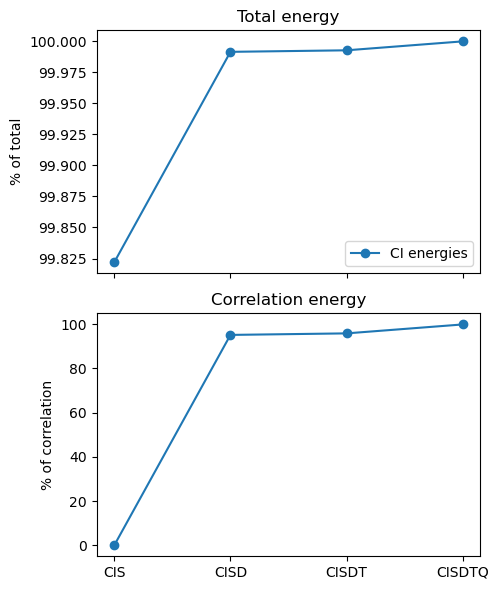

Recovered electron correlation:
  CIS   : 3.148e-11
  CISD  : 95.14
  CISDT : 95.84
  CISDTQ: 99.88


In [26]:
import matplotlib.pyplot as plt

corr_perc = (energies - E_hf) / (E_FCI - E_hf) * 100
methods = ["CIS", "CISD", "CISDT", "CISDTQ"]

plt.figure(figsize=(5, 6))
plt.subplot(211)
plt.plot(energies / E_FCI * 100, "o-", label="CI energies")
plt.title("Total energy")
plt.xticks([0, 1, 2, 3], ())
plt.ylabel("% of total")
plt.legend()

plt.subplot(212)
plt.plot(corr_perc, "o-")
plt.title("Correlation energy")
plt.xticks([0, 1, 2, 3], methods)
plt.ylabel("% of correlation")
plt.tight_layout()
plt.show()

print("Recovered electron correlation:")
for i in range(len(methods)):
    # (Energies-E_hf)/(E_FCI-E_hf)*100:
    print(f"  {methods[i]:6}: {corr_perc[i]:.4}")

The total energy of CIS is only approximately 2% too low, but it does not recover any correlation (the optimized HF determinant does not interact with single excitations). In general, the odd excitation orders do not add much to the correlation energy. However, already with CISD, we recover more than 95% of the correlation energy, and that number rises to nearly 99.9% with CISDTQ. This is remarkable as water has 10 electrons, and thus up to 10 excitations are included in the full CI. Looking at the determinant count, CISD has only 1,141 determinants, compared to the 828,828 of full CI.

This clearly suggests using truncated schemes, and in particular CISD as a relatively efficient way to recover most of the correlation energy.

(sec:size-consistency)=
### Size consistency

The main issue with those truncated CI methods is that as the system grows larger, the importance of higher excitations increases, and thus truncated CI captures a smaller and smaller fraction of the correlation. 

This is very well illustrated when taking two identical molecules at large distance. One would normally expect the energy of this non-interacting dimer to be exactly twice that of the monomer. Let's verify it on our water molecule:

In [27]:
# Two water molecules at 100 Å distance
dimer_xyz = """6
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.740848095288        0.582094932012                         
H    0.000000000000       -0.740848095288        0.582094932012
O  100.000000000000        0.000000000000        0.000000000000                         
H  100.000000000000        0.740848095288        0.582094932012                         
H  100.000000000000       -0.740848095288        0.582094932012
"""

molecule = vlx.Molecule.read_xyz_string(dimer_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G", ostream=None)

In [28]:
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [29]:
scf_results = scf_drv.compute(molecule, basis)

space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.cisd()
ci_results = ci_drv.compute(molecule, basis, space)

E_2h2o = ci_results["energies"][0]

In [30]:
print("=" * 26)
print("CISD energy")
print("-" * 26)
print(f"Dimer       : {E_2h2o:12.6f}")
print(f"Two monomers: {2 * energies[1]:12.6f}")
print(f"Difference  : {E_2h2o - 2 * energies[1]:12.6f}")
print("=" * 26)

CISD energy
--------------------------
Dimer       :  -152.215193
Two monomers:  -152.224357
Difference  :     0.009163


The calculation for the dimer found the energy to be higher than twice the monomer, and not equal as one would expect. This systematic failure of truncated CI is called the size-consistency error.

To understand this, let us consider a molecule $A$ whose CI expansion consists of only two Slater determinants --- the HF reference and a SD generated by exciting 2 electrons from orbitals $i, j$ to $a, b$:

$$
| \Psi_A \rangle = c_{0} | ... ij ...\rangle + c_{ijab} | ... ab ...\rangle
$$

Now add second molecule $B$ with two SDs, a HF reference and one being generated from a $klcd$ excitation:

$$
| \Psi_B \rangle = c'_{0} | ... kl ...\rangle + c'_{klcd} | ... cd ...\rangle
$$

In a correct calculation, as the two systems are far apart, the combined wave function can be expressed as a product of their individual ones:

\begin{align*}
| \Psi_{AB} \rangle &= | \Psi_A \Psi_B \rangle \\
                    &= \Big( c_{0} | ... ij ...\rangle + c_{ijab} | ... ab ...\rangle \Big) \Big(c'_{0} | ... kl ...\rangle + c'_{klcd} | ... cd ...\rangle \Big) \\
                    &= c_0 c'_0 | ... ij...kl ...\rangle + c_{0}c'_{klcd} | ... ij...cd ...\rangle \\ & \qquad + c_{ijab}c'_{0} | ... ab...kl ...\rangle + c_{ijab}c'_{klcd} | ... ab...cd ...\rangle   \\
\end{align*}

The last term corresponds to a quadruple excitation from the HF reference. Since these quadruple excitations are excluded from CISD, it is clear the method cannot describe the combined system as well as it can describe the individual subsystems.

Some approximations exist to partially correct for this error. One of the simplest is the Davidson correction, in which the contributions from the quadruply excited determinants are estimated using a reasoning based on perturbation theory:

$$
\Delta E_\mathrm{Davidson} = (1 - c_0^2)(E_{\rm CISD} - E_{\rm HF}), 
$$


In [31]:
# Weight of the HF determinant for the dimer
ci_results["ci_vectors"].print(0)

Determinant                  coef.    weight 
22222222220000000000000000  -0.965    0.932 



In [32]:
# Recompute 1 water molecule
basis = vlx.MolecularBasis.read(H2O, "6-31G", ostream=None)
space = mtp.OrbSpace(H2O, H2O_orbs)
space.cisd()
ci_results = ci_drv.compute(H2O, basis, space)

In [33]:
# Weight of the HF determinant for the monomer
ci_results["ci_vectors"].print(0)

Determinant     coef.    weight 
2222200000000  -0.981    0.962 



In [34]:
E_D_2H2O = (1 - 0.932) * (E_2h2o - scf_drv.get_scf_energy()) + E_2h2o
E_D_H2O = (1 - 0.962) * (ci_results["energies"][0] - E_hf) + ci_results["energies"][0]

print("=" * 26)
print("Davidson corrected energy")
print("-" * 26)
print(f"Dimer       : {E_D_2H2O:12.6f}")
print(f"Two monomers: {2 * E_D_H2O:12.6f}")
print(f"Difference  : {E_D_2H2O - 2 * E_D_H2O:12.6f}")
print("=" * 26)

Davidson corrected energy
--------------------------
Dimer       :  -152.232092
Two monomers:  -152.234148
Difference  :     0.002056


With this, the size-consistency error has been noticeably reduced.

Despite this, truncated CI have for the most part disappeared from the quantum chemistry landscape as more efficient and/or more accurate methods supplanted them.